## Spec2Pipeline for MRS   (MIRI MRS CALSPEC2)

`Spec2Pipeline` applies additional instrumental corrections and calibrations to count rate products that result in a fully calibrated individual exposure.

Official documentation for `Spec2Pipeline` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html>

The `Spec2Pipeline` for MRS comprises a linear series of steps. The steps in order are:

|Step|Description|
|:---|:---|
|`assign_wcs`|attach WCS object to each science exposure|
|`background`|subtract dedicated background exposures|
|`flat_field`|correct the exposure using the flat-field reference file|
|`srctype`|if APT source type set to 'UNKNOWN', sets the 'SRCTYPE' keyword to 'EXTENDED' for MRS|
|`straylight`|remove straylight for Channels 1/2 by interpolating across the inter-slice regions|
|`fringe`|divide the data/error arrays by a fringe reference image|
|`photom`|apply flux (photometric) calibration|
|`cube_build`|produce 3D spectral cubes from the 2D detector image|
|`extract_1d`|extract 1D spectrum from 3D cube|

Note that `cube_build` and `extract_1d` are not calibration steps but are contained in `Spec2Pipeline` to provide users with cubes and 1D spectra from each exposure. Most users of these notebooks may not want to run these steps as they are only interested in the calibrated detector images and the `cube_build` step in particular will dramatically processing time. Therefore, these steps will be skipped.

In this example, no background exposure will be provided so the `background` step will not be run.


### Input data

An example of running the file through the `Spec2Pipeline` is now shown using a simple simulated fullband, 4-point dither observation of a point source (power law plus emission lines spectrum) with the MIRI MRS produced with [MIRISim v2.3](https://wiki.miricle.org/Public/MIRISim_Public) and brought to level 2A using the `Detector1Pipeline`.

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call
from jwst import datamodels
from jwst.associations.lib.member import Member
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0641.pmap"

`Spec2Pipeline` can be run by passing indivual exposures or datamodels but in this sample case we produce an association file so all can be run through `Spec2Pipeline` in a single call. It is assumed that the science files are in 'MRS/SHORT', 'MRS/MEDIUM', and 'MRS/LONG'. The content of the association file is printed for inspection.

In [3]:
# load the science and background files to lists
my_science_files = glob.glob('MRS_science/*/*rate.fits')
my_science_files = sorted(my_science_files)

# setup an empty level 2 association structure
asn = asn_from_list(my_science_files, rule=DMSLevel2bBase)
asn.data['products'] = None

# set the association name
asn_name = 'my_point_source'

# set some metadata
asn['asn_pool'] = asn_name + '_pool'
asn['asn_type'] = 'spec2'

for n, sci in enumerate(my_science_files):
    asn.new_product('{}_exposure{}'.format(asn_name, str(n+1)))
    sci_member = Member({'expname': sci, 'exptype': 'science'})    
    new_members = asn.current_product['members']
    new_members.append(sci_member)
        
# print the association and save to file
name, ser = asn.dump()
print(ser)

asn_file = asn_name + '_lvl2_asn.json'
with open(asn_file, 'w') as f:
    f.write(ser)

{
    "asn_type": "spec2",
    "asn_rule": "DMSLevel2bBase",
    "version_id": null,
    "code_version": "0.17.1",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "asn_pool": "my_point_source_pool",
    "products": [
        {
            "name": "my_point_source_exposure1",
            "members": [
                {
                    "expname": "MRS_science/LONG/det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure2",
            "members": [
                {
                    "expname": "MRS_science/LONG/det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure3",
            "members": [
                

Import Spec2Pipeline and print the docstring to show some information

In [4]:
from jwst.pipeline import Spec2Pipeline
print(Spec2Pipeline.__doc__)


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, barshadow,  photom,
    resample_spec, cube_build, and extract_1d.
    


The association file is passed as input. The output level 2B files will be saved in `my_output_dir` as `_cal.fits`. The cubes and 1D spectra will also be saved.

*Parameters used:*
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file
    
`output_dir` : boolean, optional, default is the working directory   
&nbsp;&nbsp;&nbsp;&nbsp; the location to save the output

`steps` : dict, optional, default None  
&nbsp;&nbsp;&nbsp;&nbsp; pass parameters to steps


In [7]:
# user specified
my_output_dir = 'MRS_science'

# the output directory should be created if it doesn't exist
if not os.path.exists(my_output_dir): 
    os.mkdir(my_output_dir)

# run the pipeline
Spec2Pipeline.call(asn_file, save_results=True, output_dir=my_output_dir, 
                   steps={'cube_build': {'skip': True}, 'extract_1d': {'skip': True}})


2020-10-15 14:08:11,970 - CRDS - ERROR -  Error determining best reference for 'pars-backgroundstep'  =   Unknown reference type 'pars-backgroundstep'
2020-10-15 14:08:12,029 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   Unknown reference type 'pars-assignwcsstep'
2020-10-15 14:08:12,093 - CRDS - ERROR -  Error determining best reference for 'pars-imprintstep'  =   Unknown reference type 'pars-imprintstep'
2020-10-15 14:08:12,152 - CRDS - ERROR -  Error determining best reference for 'pars-msaflagopenstep'  =   Unknown reference type 'pars-msaflagopenstep'
2020-10-15 14:08:12,213 - CRDS - ERROR -  Error determining best reference for 'pars-extract2dstep'  =   Unknown reference type 'pars-extract2dstep'
2020-10-15 14:08:12,276 - CRDS - ERROR -  Error determining best reference for 'pars-flatfieldstep'  =   Unknown reference type 'pars-flatfieldstep'
2020-10-15 14:08:12,335 - CRDS - ERROR -  Error determining best reference for 'pars-pathlossstep'  =   

2020-10-15 14:08:13,848 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2020-10-15 14:08:13,853 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2020-10-15 14:08:13,853 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2020-10-15 14:08:13,854 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2020-10-15 14:08:13,855 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2020-10-15 14:08:13,855 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2020-10-15 14:08:13,856 - s

2020-10-15 14:08:20,177 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-10-15 14:08:20,186 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2020-10-15 14:08:20,187 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2020-10-15 14:08:20,187 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2020-10-15 14:08:20,188 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED
2020-10-15 14:08:20,189 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2020-10-15 14:08:20,602 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_imag

2020-10-15 14:08:27,780 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2020-10-15 14:08:27,781 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2020-10-15 14:08:27,782 - stpipe.Spec2Pipeline - INFO - Finished processing product my_point_source_exposure1
2020-10-15 14:08:27,783 - stpipe.Spec2Pipeline - INFO - Processing product my_point_source_exposure2
2020-10-15 14:08:27,783 - stpipe.Spec2Pipeline - INFO - Working on input MRS_science/LONG/det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits ...
2020-10-15 14:08:28,262 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).
2020-10-15 14:08:28,263 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 's

2020-10-15 14:08:44,851 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:08:44,852 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:08:44,852 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:08:46,172 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.
2020-10-15 14:08:46,173 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done
2020-10-15 14:08:46,762 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).
2020-10-15 14:08:46,764 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'out

2020-10-15 14:08:56,410 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>, []).
2020-10-15 14:08:56,412 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': ''}
2020-10-15 14:08:56,412 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2020-10-15 14:08:56,413 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2020-10-15 14:08:56,930 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).
2020-10-15 14:08:56,932 - stpipe.Spec2Pipeline.m

2020-10-15 14:09:04,921 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG
2020-10-15 14:09:04,983 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:09:04,997 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2020-10-15 14:09:05,595 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from MRS_science/my_point_source_exposure3_cal.fits>,).
2020-10-15 14:09:05,597 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'cube_build', 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting'

2020-10-15 14:09:16,235 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2020-10-15 14:09:16,838 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).
2020-10-15 14:09:16,839 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'straylight', 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}
2020-10-15 14:09:16,849 - stpipe.Spec2Pipeline.straylight - INFO - Using regions reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_regions_0028.asdf
2020-10-15 14:09:16,874 - stpipe.Spec2Pipeline.straylight - INFO -  Using 20% throughput threshhold.
2020-10-15 14:09:16,875 - stpipe.Spec

2020-10-15 14:09:32,084 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_specwcs_0023.asdf', 'regions': '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_regions_0030.asdf', 'wavelengthrange': '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}
2020-10-15 14:09:32,858 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.000000000 -0.001185998 359.999999999 -0.001185998 359.999999999 0.001071963 0.000000000 0.001071963
2020-10-15 14:09:32,858 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_w

2020-10-15 14:09:40,647 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2020-10-15 14:09:41,342 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).
2020-10-15 14:09:41,343 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'barshadow', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2020-10-15 14:09:41,344 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.
2020-10-15 14:09:41,345 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done
2020-10-15 14:09:41,919 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.f

2020-10-15 14:09:51,386 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2020-10-15 14:09:51,388 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2020-10-15 14:09:51,997 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).
2020-10-15 14:09:51,998 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'srctype', 'search_output_file': True, 'input_dir': ''}
2020-10-15 14:09:52,008 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2020-10-15 14:09:52,009 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2020-10-15 14:09:52,010 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE

2020-10-15 14:10:07,068 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.
2020-10-15 14:10:07,069 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done
2020-10-15 14:10:07,699 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from MRS_science/my_point_source_exposure6_cal.fits>,).
2020-10-15 14:10:07,702 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}
2020-10-15 14:10:07,703 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2020-10-15 14:10:07,704 - stpipe.Spec2Pipeline.extract_1d - INFO - Step e

2020-10-15 14:10:18,643 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'fringe', 'search_output_file': True, 'input_dir': ''}
2020-10-15 14:10:18,654 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0044.fits
2020-10-15 14:10:18,694 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:10:18,695 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:10:18,695 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2020

2020-10-15 14:10:30,292 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'bkg_subtract', 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}
2020-10-15 14:10:30,292 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2020-10-15 14:10:30,293 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2020-10-15 14:10:30,957 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).
2020-10-15 14:10:30,959 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_mod

2020-10-15 14:10:45,850 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2020-10-15 14:10:45,863 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0064.fits
2020-10-15 14:10:45,864 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2020-10-15 14:10:47,159 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2020-10-15 14:10:47,160 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT
2020-10-15 14:10:47,160 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS
2020-10-15 14:10:47,161 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM
2020-10-15 14:

2020-10-15 14:10:56,262 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED
2020-10-15 14:10:56,263 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2020-10-15 14:10:57,007 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).
2020-10-15 14:10:57,010 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2020-10-15 14:10:57,084 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2020-10

2020-10-15 14:11:06,437 - stpipe.Spec2Pipeline - INFO - Processing product my_point_source_exposure10
2020-10-15 14:11:06,438 - stpipe.Spec2Pipeline - INFO - Working on input MRS_science/SHORT/det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits ...
2020-10-15 14:11:07,181 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2020-10-15 14:11:07,183 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2020-10-15 14:11:10,855 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/Users/patrickkavanagh/crds_mirror/

2020-10-15 14:11:24,970 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0046.fits
2020-10-15 14:11:25,013 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:11:25,014 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:11:25,014 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:11:26,302 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.
2020-10-15 14:11:26,304 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done
2020-10-15 14:11:27,123 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_se

2020-10-15 14:11:37,122 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2020-10-15 14:11:37,122 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2020-10-15 14:11:37,845 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>, []).
2020-10-15 14:11:37,846 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': ''}
2020-10-15 14:11:37,847 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2020-10-15 14:11:37,848 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2020-10-15 14:11:38,564 - stpipe.Spec2Pipeline.msa_flagging -

2020-10-15 14:11:48,142 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG
2020-10-15 14:11:48,143 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS
2020-10-15 14:11:48,144 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT
2020-10-15 14:11:48,211 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:11:48,227 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2020-10-15 14:11:49,317 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from MRS_science/my_point_source_exposure11_cal.fits>,).
2020-10-15 14:11:49,320 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'cube_build', 'search_output_file': Fal

2020-10-15 14:11:59,511 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:11:59,512 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:11:59,512 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:11:59,517 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2020-10-15 14:12:00,811 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2020-10-15 14:12:01,578 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2020-10-15 14:12:01,580 - stpipe.Spec2Pipeline.straylight - INFO - Step strayligh

2020-10-15 14:12:15,548 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2020-10-15 14:12:16,487 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_science/my_point_source_exposure1_cal.fits
2020-10-15 14:12:17,610 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_science/my_point_source_exposure2_cal.fits
2020-10-15 14:12:18,517 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_science/my_point_source_exposure3_cal.fits
2020-10-15 14:12:19,638 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_science/my_point_source_exposure4_cal.fits
2020-10-15 14:12:21,430 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_science/my_point_source_exposure5_cal.fits
2020-10-15 14:12:22,556 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_science/my_point_source_exposure6_cal.fits
2020-10-15 14:12:23,580 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_science/my_point_source_exposure7_cal.fits
2020-10-15 14:12:25,004 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_science/my_point_sourc

[<IFUImageModel(1024, 1032) from my_point_source_exposure1_cal.fits>,
 <IFUImageModel(1024, 1032) from my_point_source_exposure2_cal.fits>,
 <IFUImageModel(1024, 1032) from my_point_source_exposure3_cal.fits>,
 <IFUImageModel(1024, 1032) from my_point_source_exposure4_cal.fits>,
 <IFUImageModel(1024, 1032) from my_point_source_exposure5_cal.fits>,
 <IFUImageModel(1024, 1032) from my_point_source_exposure6_cal.fits>,
 <IFUImageModel(1024, 1032) from my_point_source_exposure7_cal.fits>,
 <IFUImageModel(1024, 1032) from my_point_source_exposure8_cal.fits>,
 <IFUImageModel(1024, 1032) from my_point_source_exposure9_cal.fits>,
 <IFUImageModel(1024, 1032) from my_point_source_exposure10_cal.fits>,
 <IFUImageModel(1024, 1032) from my_point_source_exposure11_cal.fits>,
 <IFUImageModel(1024, 1032) from my_point_source_exposure12_cal.fits>]

We can plot the before (rate) and after (cal) images for the first dither position of the SHORT band

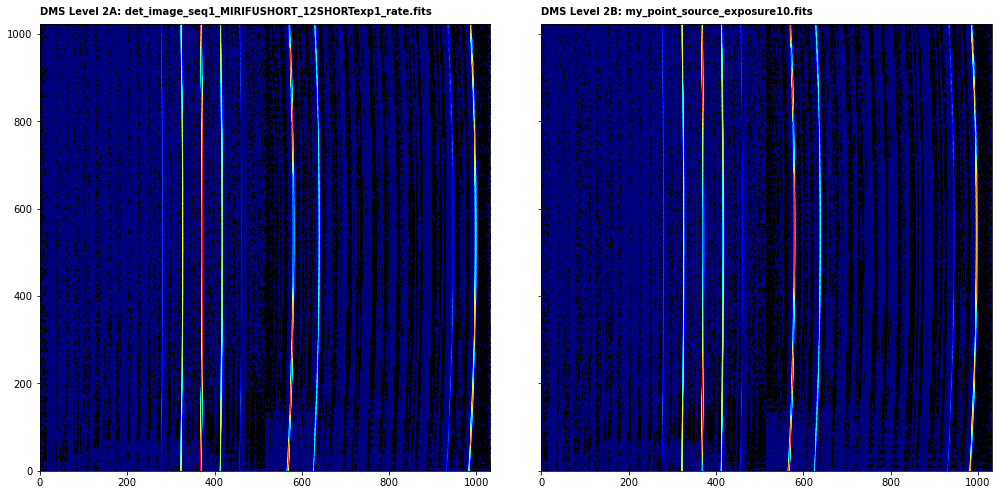

In [6]:
# use the association to identify the linked files
cal_file = asn['products'][9]['name'] + '.fits'
rate_file = asn['products'][9]['members'][0]['expname']

# open the input level 2A image and calibrated 2B image a jwst data models
with datamodels.open(rate_file) as in_dm:
    with datamodels.open(rate_file) as out_dm:

        fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

        axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1, vmax=100))
        axs[0].annotate('DMS Level 2A: {}'.format(os.path.basename(rate_file)), xy=(0.0, 1.02), xycoords='axes fraction', 
                        fontsize=10, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1, vmax=100))
        axs[1].annotate('DMS Level 2B: {}'.format(cal_file), xy=(0.0, 1.02), xycoords='axes fraction', 
                        fontsize=10, fontweight='bold', color='k')
        axs[1].set_facecolor('black')
        plt.tight_layout()
        plt.show()


### Command line

To achieve the same result from the command line there are a couple of options. However, one must still generate the association file. In this case, it is best to copy the template above into a text file and save it to `my_point_source_lvl2_asn.json`. The content is printed here for convenience.

```python
{
    "asn_type": "spec2",
    "asn_rule": "DMSLevel2bBase",
    "version_id": null,
    "code_version": "0.13.7",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "products": [
        {
            "name": "my_point_source_exposure1",
            "members": [
                {
                    "expname": "MRS/LONG/det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure2",
            "members": [
                {
                    "expname": "MRS/LONG/det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure3",
            "members": [
                {
                    "expname": "MRS/LONG/det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure4",
            "members": [
                {
                    "expname": "MRS/LONG/det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure5",
            "members": [
                {
                    "expname": "MRS/MEDIUM/det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure6",
            "members": [
                {
                    "expname": "MRS/MEDIUM/det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure7",
            "members": [
                {
                    "expname": "MRS/MEDIUM/det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure8",
            "members": [
                {
                    "expname": "MRS/MEDIUM/det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure9",
            "members": [
                {
                    "expname": "MRS/SHORT/det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure10",
            "members": [
                {
                    "expname": "MRS/SHORT/det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure11",
            "members": [
                {
                    "expname": "MRS/SHORT/det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure12",
            "members": [
                {
                    "expname": "MRS/SHORT/det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        }
    ],
    "asn_pool": "my_point_source_pool"
}
```

**Option 1:**
Run the `Spec2Pipeline` class using the `strun` command:

```bash
mkdir demo_output

strun jwst.pipeline.Spec2Pipeline my_point_source_lvl2_asn.json --output_dir demo_output --steps.photom.save_results True --steps.cube_build.skip True --steps.extract_1d.skip True
```

This will produce the same output file in the user-defined `--output_dir`


**Option 2:**
Collect the pipeline configuration files in your working directory (if they are not already there) using `collect_pipeline_configs` and then run the `Spec2Pipeline` using the `strun` command with the associated `calwebb_spec2.cfg` file. This option is a little more flexible as one can create edit the cfg files, use them again, etc.

```bash
mkdir demo_output

collect_pipeline_cfgs cfgs/

strun cfgs/calwebb_spec2.cfg my_point_source_lvl2_asn.json --output_dir demo_output --steps.photom.save_results True --steps.cube_build.skip True --steps.extract_1d.skip True
```

This will produce the same output file in the user-defined `--output_dir`

## Further examples

Other notebooks with more complex examples can be found here:

*To be added*